In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import rotate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [2]:
def view_data(data: torch.Tensor, label: torch.Tensor, n: int) -> plt.Figure:
    
    arab_labs = ['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط' , 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى']

    fig, axs = plt.subplots(1, n, figsize=(21, 5))
    for i_ax, ax in enumerate(axs):
        ax.imshow(data[i_ax, :, :, :], cmap=plt.gray())
        ax.set_title("Label = %s" % (arab_labs[int(label[i_ax].item())]))
        ax.set_xticks([])
        ax.set_yticks([])
    return fig


def view_data_rand(loader: torch.utils.data.DataLoader, n: int = 10) -> plt.Figure:

    rand_data, rand_label = next(iter(loader))

    return view_data(rand_data, rand_label, n)

In [3]:
trainx = rotate(np.flip(
    pd.read_csv("../dataset/csvTrainImages 13440x1024.csv",
                header=None).values.astype('float32').reshape([-1, 32, 32, 1]),
    1),
                -90,
                axes=(1, 2))
trainy = pd.read_csv("../dataset/csvTrainLabel 13440x1.csv",
                     header=None).values.astype('int32') - 1

testx = rotate(np.flip(
    pd.read_csv("../dataset/csvTestImages 3360x1024.csv",
                header=None).values.astype('float32').reshape([-1, 32, 32, 1]),
    1),
               -90,
               axes=(1, 2))
testy = pd.read_csv("../dataset/csvTestLabel 3360x1.csv",
                    header=None).values.astype('int32') - 1

In [4]:
data_train = TensorDataset(torch.Tensor(trainx), torch.Tensor(trainy))

train_loader = DataLoader(data_train, batch_size=100, shuffle=True)

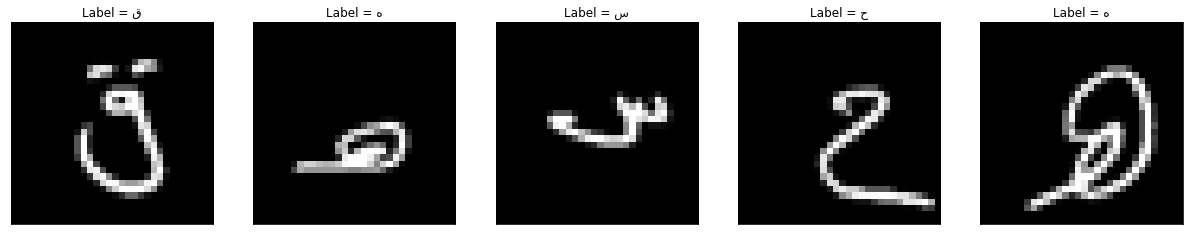

In [5]:
plts = view_data_rand(train_loader, n=5)

# The Network (Sins and Bros certified)

In [13]:
class SinsNet(nn.Module):
    
    def __init__(self):
        
        super(SinsNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(1024, 1000)
        self.fc2 = nn.Linear(1000, 28)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [14]:
loss_list = []
acc_list = []
model = SinsNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(20):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item(),
                          (correct / total) * 100))


RuntimeError: Given groups=1, weight of size [32, 1, 5, 5], expected input[100, 32, 32, 1] to have 1 channels, but got 32 channels instead